In [2]:
import pandas as pd
import numpy as np
from functions_NLM import estimate_nested_logit

<h2> We choose the following nest : measured vs flat 

Options 1 and 2 are measured, options 3, 4 and 5 are flat </h2>

In [2]:
# Define log-likelihood function for telephone data
# beta will be beta = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST", "lambda_measured", "lambda_flat"]

def log_likelihood_telephone(beta, data):
    # Define utility functions
    data['U_1'] = beta[0] + beta[4] * data['logcost1'] 
    data['U_2'] = beta[4] * data['logcost2'] 
    data['U_3'] = beta[1] + beta[4] * data['logcost3']
    data['U_4'] = beta[2] + beta[4] * data['logcost4']
    data['U_5'] = beta[3] + beta[4] * data['logcost5']
    
    # Calculate logsum for nests with > 1 alt
    data['logsum_measured'] = np.log(data['avail1'] * np.exp(data['U_1'] / beta[5])
                                        + data['avail2'] * np.exp(data['U_2'] / beta[5])
                                        + (1 - data['avail1']) * (1 - data['avail2']))
    data['logsum_flat'] = np.log(data['avail3'] * np.exp(data['U_3'] / beta[6])
                                    + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                    + data['avail5'] * np.exp(data['U_5'] / beta[6])
                                    + (1 - data['avail3']) * (1 - data['avail4']) * (1 - data['avail5']))
    
    # Nest probabilities
    data['P_nest_measured'] = np.exp(beta[5] * data['logsum_measured']) / \
                                 (np.exp(beta[5] * data['logsum_measured']) 
                                  + np.exp(beta[6] * data['logsum_flat']))
    data['P_nest_flat'] = 1 - data['P_nest_measured']
    
    # Within nest probabilities for nests with > 1 alt
    data['P_1_in_measured'] = data['avail1'] * np.exp(data['U_1'] / beta[5]) / \
                                (data['avail1'] * np.exp(data['U_1'] / beta[5]) 
                                 + data['avail2'] * np.exp(data['U_2'] / beta[5]))
    data['P_2_in_measured'] = 1 - data['P_1_in_measured']

    data['P_3_in_flat'] = data['avail3'] * np.exp(data['U_3'] / beta[6]) / \
                            (data['avail3'] * np.exp(data['U_3'] / beta[6])
                                + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                + data['avail5'] * np.exp(data['U_5'] / beta[6]))
    data['P_4_in_flat'] = data['avail4'] * np.exp(data['U_4'] / beta[6]) / \
                            (data['avail3'] * np.exp(data['U_3'] / beta[6])
                                + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                + data['avail5'] * np.exp(data['U_5'] / beta[6]))
    data['P_5_in_flat'] = 1 - data['P_3_in_flat'] - data['P_4_in_flat']
    
    # Full probabilities
    data['P_1'] = data['P_nest_measured'] * data['P_1_in_measured']
    data['P_2'] = data['P_nest_measured'] * data['P_2_in_measured']
    data['P_3'] = data['P_nest_flat'] * data['P_3_in_flat']
    data['P_4'] = data['P_nest_flat'] * data['P_4_in_flat']
    data['P_5'] = data['P_nest_flat'] * data['P_5_in_flat']
    
    # Calculate probability for chosen alternative for each row
    data['P'] = (data['choice'] == 1) * data['P_1'] + \
                (data['choice'] == 2) * data['P_2'] + \
                (data['choice'] == 3) * data['P_3'] + \
                (data['choice'] == 4) * data['P_4'] + \
                (data['choice'] == 5) * data['P_5']
    
    # Replace zero probabilities with small value to avoid LL = -inf
    epsilon = 1e-20
    data[data['P'] == 0] = epsilon
    
    # Calculate log-likelihood 
    LL = data['P'].apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood

In [3]:
# Load data
data = pd.read_csv('./data/telephone.dat', sep='\t')

data['logcost1'] = np.log(data['cost1'])
data['logcost2'] = np.log(data['cost2'])
data['logcost3'] = np.log(data['cost3'])
data['logcost4'] = np.log(data['cost4'])
data['logcost5'] = np.log(data['cost5'])

# Define model parameters
beta = np.array([0, 0, 0, 0, 0, 1, 1])
# lambda_n = 1 / mu_n is a measure of the degree of independence in unobserved utility among
# the alternatives in nest n.
# It should be between 0 and 1 with lambda_n = 1 indicating full independence.
beta_names = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST", "lambda_measured", "lambda_flat"]


In [4]:
# Estimate parameters
result, se, t_stat, p_value = estimate_nested_logit(data, beta, beta_names, log_likelihood_telephone)


Optimization Results:
         Parameter  Estimate  Robust Asymptotic SE  t-statistic       p-value
0            ASC_1 -0.378246              0.125454    -3.015006  2.723024e-03
1            ASC_3  0.893446              0.171565     5.207627  2.980374e-07
2            ASC_4  0.847293              0.393757     2.151815  3.197195e-02
3            ASC_5  1.405502              0.259374     5.418828  1.004633e-07
4        BETA_COST -1.490024              0.252883    -5.892149  7.739943e-09
5  lambda_measured  0.484798              0.139705     3.470160  5.730726e-04
6      lambda_flat  0.436216              0.121307     3.595981  3.609402e-04


<h2> P_i corresponds to p(y=i | x) because we have different probabilities for each individual. </h2>

In [80]:
data.head(15)

,choice,area,users,inc,age0,age1,age2,age3,age4,age5,...,P_4_in_flat,P_5_in_flat,P_1,P_2,P_3,P_4,P_5,P,choice_nest,cluster
0,2,1,2,4,0,0,0,1,1,0,...,0.0,0.292626,0.178980,0.398890,0.298604,0.0,0.123526,0.398890,1,1
1,3,1,1,2,0,0,0,0,0,0,...,0.0,0.266792,0.444340,0.211141,0.252604,0.0,0.091915,0.252604,2,1
2,1,2,2,4,0,0,0,2,0,0,...,0.0,0.129136,0.233773,0.345103,0.366742,0.0,0.054382,0.233773,1,1
3,3,2,2,3,1,0,0,0,2,0,...,0.0,0.097662,0.255216,0.304637,0.397161,0.0,0.042986,0.397161,2,1
4,3,2,6,3,1,3,2,1,0,2,...,0.0,0.240819,0.108763,0.429351,0.350655,0.0,0.111231,0.350655,2,1
5,3,2,2,2,1,0,0,2,0,0,...,0.0,0.189674,0.067942,0.200225,0.593024,0.0,0.138809,0.593024,2,1
6,3,2,1,1,0,0,0,0,0,0,...,0.0,0.144653,0.238626,0.352267,0.349929,0.0,0.059179,0.349929,2,1
7,1,2,2,5,1,0,0,1,1,0,...,0.0,0.092003,0.443658,0.182730,0.339238,0.0,0.034373,0.443658,1,1
8,5,2,4,4,1,1,0,0,2,0,...,0.0,0.900332,0.050661,0.126524,0.082008,0.0,0.740807,0.740807,2,2
9,3,2,2,5,0,0,0,2,0,0,...,0.0,0.691179,0.073277,0.197027,0.225345,0.0,0.504350,0.225345,2,2


In [87]:
data_logcost = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]

# Calculate the sum of the log costs for each row
data_logcost['sum_logcost'] = data_logcost[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']].sum(axis=1)

# Compute the empirical distribution
empirical_distribution = data_logcost['sum_logcost'].value_counts(normalize=True)

# Add a column "probability" to the DataFrame
data_logcost['probability'] = data_logcost['sum_logcost'].map(empirical_distribution)

# Print the updated DataFrame
data_logcost.head(15)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_11490/3194197758.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_logcost['sum_logcost'] = data_logcost[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']].sum(axis=1)
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_11490/3194197758.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_logcost['probability'] = data_logcost['sum_logcost'].map(empirical_distribution)


,logcost1,logcost2,logcost3,logcost4,logcost5,sum_logcost,probability
0,1.761300,1.754404,2.545531,13.815511,3.147595,23.024340,0.002304
1,1.258461,1.754404,2.507972,13.815511,3.147595,22.483942,0.002304
2,1.627278,1.754404,2.439735,13.815511,3.342155,22.979082,0.002304
3,1.558145,1.754404,2.347558,13.815511,3.342155,22.817772,0.002304
4,2.145931,1.953028,2.662355,13.815511,3.342155,23.918980,0.002304
5,2.778819,2.681022,2.573375,13.815511,3.342155,25.190881,0.002304
6,1.627278,1.754404,2.478218,13.815511,3.342155,23.017565,0.002304
7,1.211941,1.754404,2.328253,13.815511,3.342155,22.452263,0.004608
8,3.552200,3.508256,3.642836,13.815511,3.342155,27.860958,0.002304
9,3.128075,3.060115,3.234355,13.815511,3.342155,26.580211,0.002304


In [9]:
p_x = data_logcost['probability'].values
p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

<h2> We try to apply IB/DIB to p(x,y) = p(y|x)p(x) where 

- p(y|x) comes from the P_i
- p(x) comes from the empirical distribution for the sum of the logcost 
</h2>

In [10]:
from functions_IB import information_bottleneck
from functions_geom_DIB import geom_DIB, DIB_curve
import matplotlib.pyplot as plt


In [11]:
# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

In [79]:
first_IB = information_bottleneck(p_xy, beta=5, max_iter=10)
first_DIB = geom_DIB(p_xy, beta=5, max_iter=10)

Iteration 0 out of 10
Iteration 1 out of 10
Iteration 2 out of 10
Iteration 3 out of 10
Iteration 4 out of 10
Iteration 5 out of 10
Iteration 6 out of 10
Iteration 7 out of 10
Iteration 8 out of 10
Iteration 9 out of 10
Iteration: 0 out of 10
Iteration: 1 out of 10
Iteration: 2 out of 10
Iteration: 3 out of 10
Iteration: 4 out of 10
Iteration: 5 out of 10
Iteration: 6 out of 10
Iteration: 7 out of 10
Iteration: 8 out of 10
Iteration: 9 out of 10


In [3]:
np.linspace(0, 100, 21)

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

Beta: 1 out of 21
Iteration: 0 out of 50
Iteration: 1 out of 50
Iteration: 2 out of 50
Iteration: 3 out of 50
Iteration: 4 out of 50
Iteration: 5 out of 50
Iteration: 6 out of 50
Iteration: 7 out of 50
Iteration: 8 out of 50
Iteration: 9 out of 50
Iteration: 10 out of 50
Iteration: 11 out of 50
Iteration: 12 out of 50
Iteration: 13 out of 50
Iteration: 14 out of 50
Iteration: 15 out of 50
Iteration: 16 out of 50
Iteration: 17 out of 50
Iteration: 18 out of 50
Iteration: 19 out of 50
Iteration: 20 out of 50
Iteration: 21 out of 50
Iteration: 22 out of 50
Iteration: 23 out of 50
Iteration: 24 out of 50
Iteration: 25 out of 50
Iteration: 26 out of 50
Iteration: 27 out of 50
Iteration: 28 out of 50
Iteration: 29 out of 50
Iteration: 30 out of 50
Iteration: 31 out of 50
Iteration: 32 out of 50
Iteration: 33 out of 50
Iteration: 34 out of 50
Iteration: 35 out of 50
Iteration: 36 out of 50
Iteration: 37 out of 50
Iteration: 38 out of 50
Iteration: 39 out of 50
Iteration: 40 out of 50
Iteratio

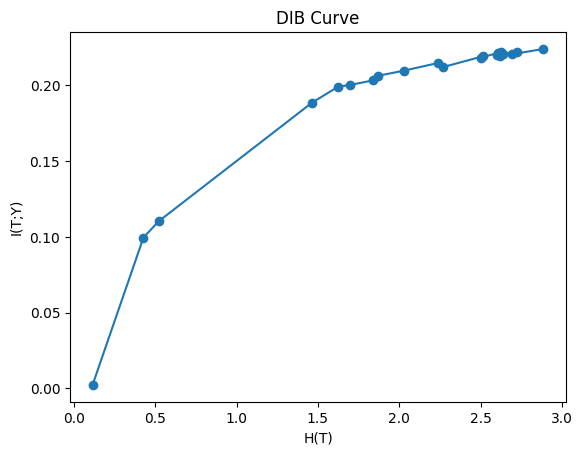

In [82]:
betas = np.linspace(0, 100, 21)
DIB_curve(p_xy, beta_values=betas, max_iter=50)

Iteration: 0 out of 100
Iteration: 1 out of 100
Iteration: 2 out of 100
Iteration: 3 out of 100
Iteration: 4 out of 100
Iteration: 5 out of 100
Iteration: 6 out of 100
Iteration: 7 out of 100
Iteration: 8 out of 100
Iteration: 9 out of 100
Iteration: 10 out of 100
Iteration: 11 out of 100
Iteration: 12 out of 100
Iteration: 13 out of 100
Iteration: 14 out of 100
Iteration: 15 out of 100
Iteration: 16 out of 100
Iteration: 17 out of 100
Iteration: 18 out of 100
Iteration: 19 out of 100
Iteration: 20 out of 100
Iteration: 21 out of 100
Iteration: 22 out of 100
Iteration: 23 out of 100
Iteration: 24 out of 100
Iteration: 25 out of 100
Iteration: 26 out of 100
Iteration: 27 out of 100
Iteration: 28 out of 100
Iteration: 29 out of 100
Iteration: 30 out of 100
Iteration: 31 out of 100
Iteration: 32 out of 100
Iteration: 33 out of 100
Iteration: 34 out of 100
Iteration: 35 out of 100
Iteration: 36 out of 100
Iteration: 37 out of 100
Iteration: 38 out of 100
Iteration: 39 out of 100
Iteration:

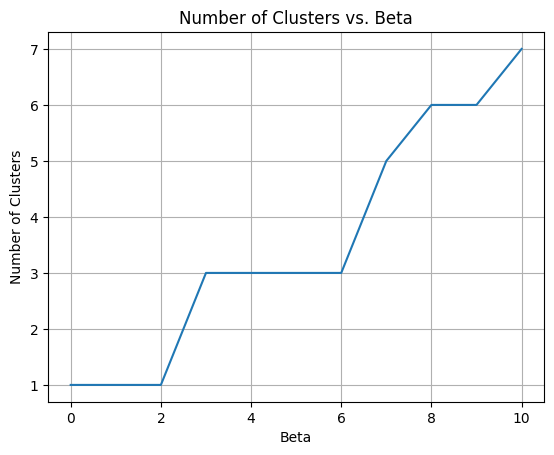

In [81]:
betas = np.linspace(0, 10, 11)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB(p_xy, max_iter=100, beta=beta)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

In [74]:
q_t_given_x, q_t, q_y_given_t = geom_DIB(p_xy, beta=5, max_iter=100)

Iteration: 0 out of 100
Iteration: 1 out of 100
Iteration: 2 out of 100
Iteration: 3 out of 100
Iteration: 4 out of 100
Iteration: 5 out of 100
Iteration: 6 out of 100
Iteration: 7 out of 100
Iteration: 8 out of 100
Iteration: 9 out of 100
Iteration: 10 out of 100
Iteration: 11 out of 100
Iteration: 12 out of 100
Iteration: 13 out of 100
Iteration: 14 out of 100
Iteration: 15 out of 100
Iteration: 16 out of 100
Iteration: 17 out of 100
Iteration: 18 out of 100
Iteration: 19 out of 100
Iteration: 20 out of 100
Iteration: 21 out of 100
Iteration: 22 out of 100
Iteration: 23 out of 100
Iteration: 24 out of 100
Iteration: 25 out of 100
Iteration: 26 out of 100
Iteration: 27 out of 100
Iteration: 28 out of 100
Iteration: 29 out of 100
Iteration: 30 out of 100
Iteration: 31 out of 100
Iteration: 32 out of 100
Iteration: 33 out of 100
Iteration: 34 out of 100
Iteration: 35 out of 100
Iteration: 36 out of 100
Iteration: 37 out of 100
Iteration: 38 out of 100
Iteration: 39 out of 100
Iteration:

In [45]:
def find_clusters(array):
    n = len(array)
    clusters = {}
    cluster_count = 0

    for i in range(n):
        row = array[i]
        index = np.argmax(row)  # Find the index of the 1 in the row
        if row[index] == 1:
            if index not in clusters:
                cluster_count += 1
                clusters[index] = cluster_count
            cluster = clusters[index]
            clusters[i] = cluster  # Store the cluster for the row index

    return clusters

In [83]:
# Find clusters
cluster_dict = find_clusters(q_t_given_x)

# Create DataFrame
df = pd.DataFrame.from_dict(cluster_dict, orient='index', columns=['Cluster'])

# Set index name
df.index.name = 'Row Index'

# Reindex the DataFrame to have row index from 0 to n
df = df.reindex(range(len(q_t_given_x)))

# Print the DataFrame
print(df)


           Cluster
Row Index         
0                1
1                1
2                1
3                1
4                1
...            ...
429              1
430              1
431              1
432              1
433              1

[434 rows x 1 columns]


In [84]:
# Count the number of unique clusters
num_clusters = len(set(cluster_dict.values()))

# Print the number of clusters
print("Number of clusters:", num_clusters)

Number of clusters: 6


In [85]:
# Create new column choice_nest which is 1 if choice= 1 or 2, and 2 otherwise
data['choice_nest'] = np.where(data['choice'].isin([1, 2]), 1, 2)
data['cluster'] = df['Cluster']

In [86]:
data['cluster'].value_counts()

cluster
1    385
2     33
4      8
3      6
5      1
6      1
Name: count, dtype: int64

In [63]:
data['choice_nest'].value_counts()

choice_nest
2    238
1    196
Name: count, dtype: int64

In [39]:
# Find rows where choice_nest is not equal to cluster
mismatched_rows = data[data['choice_nest'] != data['cluster']]

# Print the mismatched rows
print(mismatched_rows)

     choice  area  users  inc  age0  age1  age2  age3  age4  age5  ...  \
1         3     1      1    2     0     0     0     0     0     0  ...   
3         3     2      2    3     1     0     0     0     2     0  ...   
4         3     2      6    3     1     3     2     1     0     2  ...   
5         3     2      2    2     1     0     0     2     0     0  ...   
6         3     2      1    1     0     0     0     0     0     0  ...   
..      ...   ...    ...  ...   ...   ...   ...   ...   ...   ...  ...   
420       3     5      3    3     1     2     0     0     2     0  ...   
424       3     5      3    5     0     0     0     1     0     2  ...   
426       3     5      1    1     0     0     0     0     0     0  ...   
428       3     5      1    1     0     0     0     0     0     0  ...   
430       3     5      2    3     0     0     0     1     1     0  ...   

     P_4_in_flat  P_5_in_flat       P_1       P_2       P_3  P_4       P_5  \
1            0.0     0.266792  0.